In [1]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator


import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

In [4]:
spark = SparkSession.builder.master("local[1]").appName("Linear-Regression-California-Housing").getOrCreate()

/home/oscar/py3/lib/python3.6/site-packages/pyspark/context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


In [5]:
spark

In [6]:
sc = spark.sparkContext
sc

<SparkContext master=local[1] appName=Linear-Regression-California-Housing>

In [7]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

/home/oscar/py3/lib/python3.6/site-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [8]:
HOUSING_DATA = './cal_housing.data'

In [9]:
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)

The California Housing data set appeared in a 1997 paper titled Sparse Spatial Autoregressions, written by Pace, R. Kelley and Ronald Barry and published in the Statistics and Probability Letters journal. The researchers built this data set by using the 1990 California census data.

The data contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data 

 :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude


In [10]:
housing_df = spark.read.csv(path=HOUSING_DATA, schema=schema).cache()


In [11]:
housing_df.show()

+-------+-----+------+--------+--------+------+--------+------+--------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|   medhv|
+-------+-----+------+--------+--------+------+--------+------+--------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|452600.0|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|358500.0|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|352100.0|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|341300.0|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|342200.0|
|-122.25|37.85|  52.0|   919.0|   213.0| 413.0|   193.0|4.0368|269700.0|
|-122.25|37.84|  52.0|  2535.0|   489.0|1094.0|   514.0|3.6591|299200.0|
|-122.25|37.84|  52.0|  3104.0|   687.0|1157.0|   647.0|  3.12|241400.0|
|-122.26|37.84|  42.0|  2555.0|   665.0|1206.0|   595.0|2.0804|226700.0|
|-122.25|37.84|  52.0|  3549.0|   707.0|1551.0|   714.0|3.6912|261100.0|
|-122.26|37.85|  52.0|  2202.0|   434.0| 910.0|   4

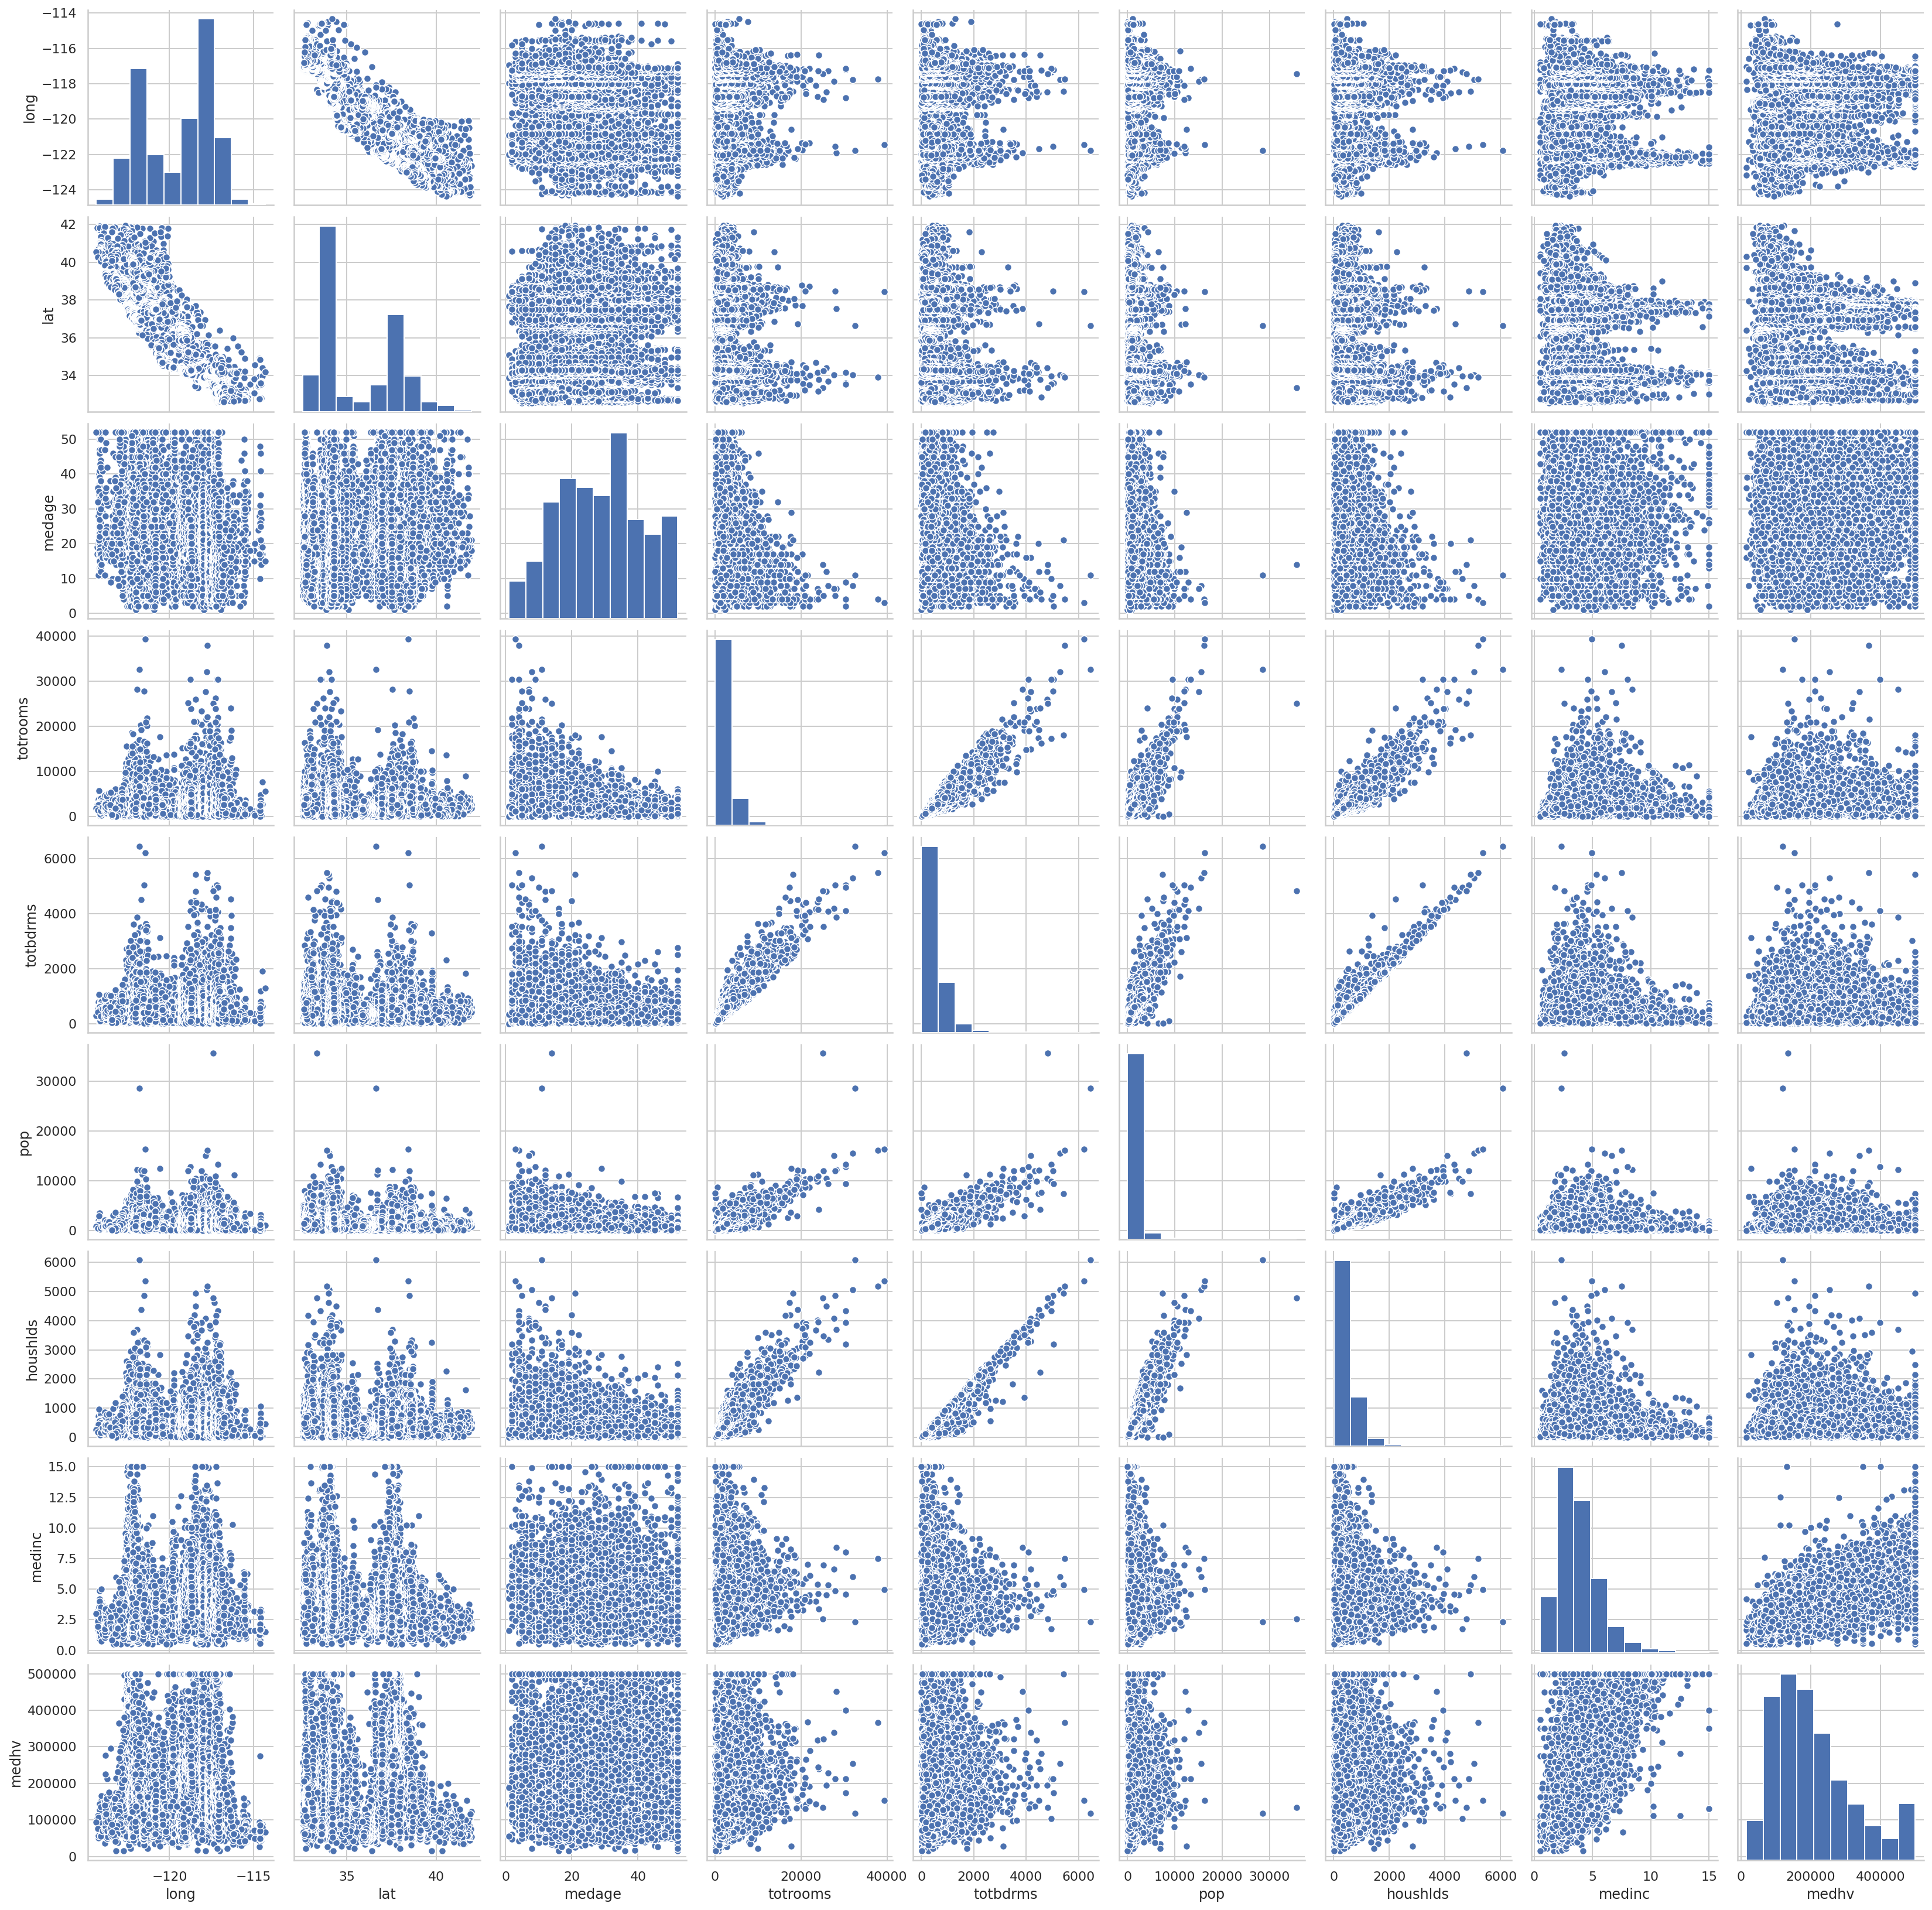

In [12]:
sns.pairplot(housing_df.toPandas())

In [13]:
housing_df.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

In [14]:


# show the schema of the dataframe
housing_df.printSchema()



root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medage: float (nullable = true)
 |-- totrooms: float (nullable = true)
 |-- totbdrms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- houshlds: float (nullable = true)
 |-- medinc: float (nullable = true)
 |-- medhv: float (nullable = true)



/home/oscar/py3/lib/python3.6/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


<AxesSubplot:>

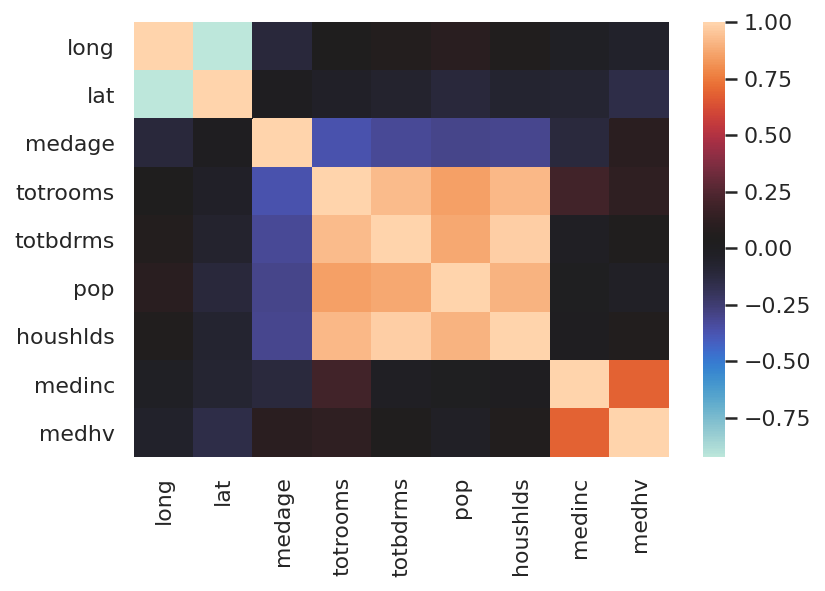

In [15]:
from pyspark.ml.stat import Correlation
# convert to vector column first
assembler = VectorAssembler(inputCols=housing_df.columns, outputCol="features")
df_vector = assembler.transform(housing_df).select("features")

# get correlation matrix
matrix = Correlation.corr(df_vector, 'features')
corrmatrix = matrix.collect()[0][0].toArray().tolist()

#Converst to pandas dataframe
df_corr = pd.DataFrame(corrmatrix, columns = housing_df.columns, index = housing_df.columns)

#plot correlation matrix by using seaborn
sns.heatmap(df_corr,cmap='icefire')

<AxesSubplot:xlabel='medinc', ylabel='medhv'>

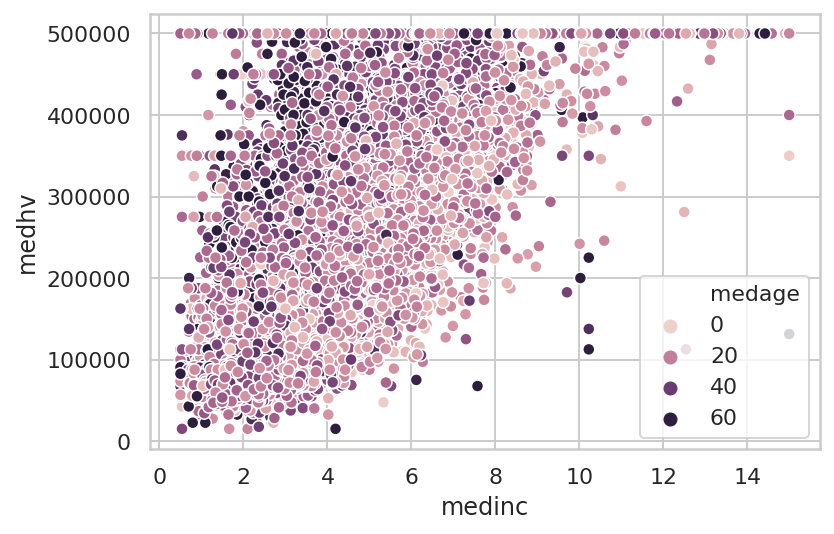

In [16]:


#Per-capita-income and prices of the home

sns.scatterplot(x = 'medinc', y = 'medhv' , hue='medage' , data= housing_df.toPandas())


<AxesSubplot:xlabel='long', ylabel='lat'>

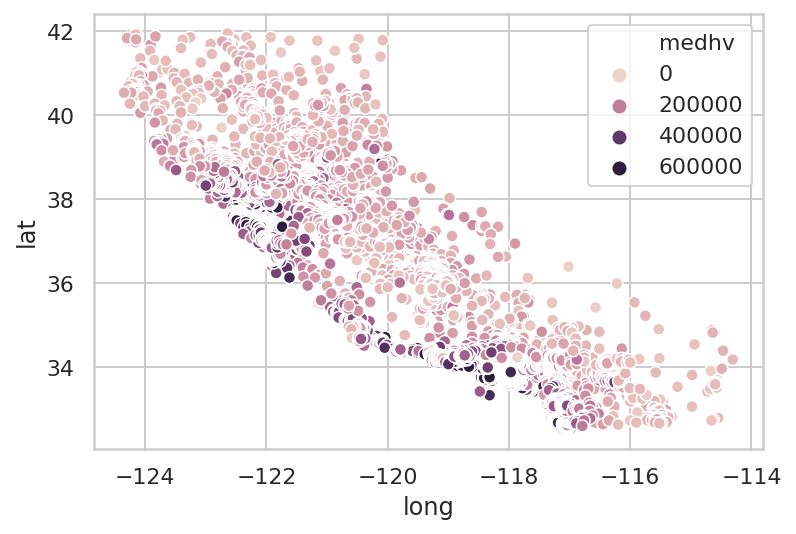

In [17]:


#Per-capita-income and prices of the home

sns.scatterplot(x = 'long', y = 'lat', hue='medhv' ,  data=housing_df.toPandas())


<AxesSubplot:xlabel='long', ylabel='lat'>

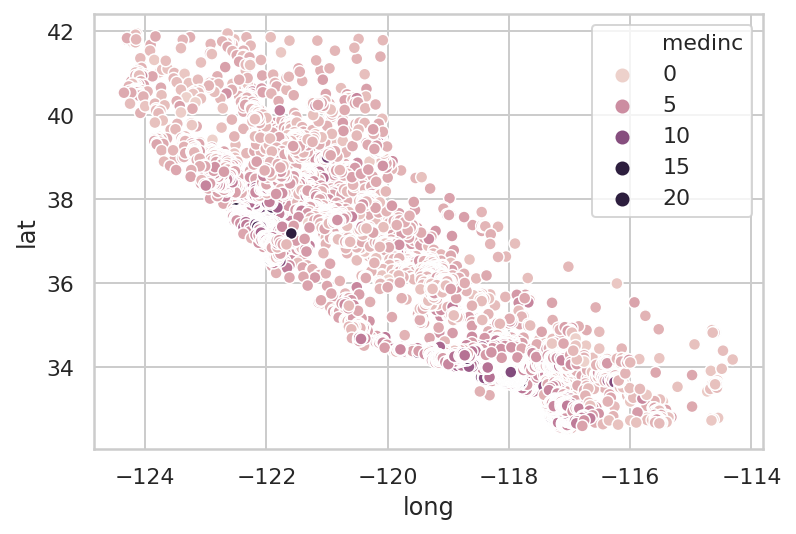

In [18]:
sns.scatterplot(x = 'long', y = 'lat', hue='medinc' ,  data=housing_df.toPandas())


In [19]:
housing_df.select('pop','totbdrms').show(10)

+------+--------+
|   pop|totbdrms|
+------+--------+
| 322.0|   129.0|
|2401.0|  1106.0|
| 496.0|   190.0|
| 558.0|   235.0|
| 565.0|   280.0|
| 413.0|   213.0|
|1094.0|   489.0|
|1157.0|   687.0|
|1206.0|   665.0|
|1551.0|   707.0|
+------+--------+
only showing top 10 rows



<AxesSubplot:>

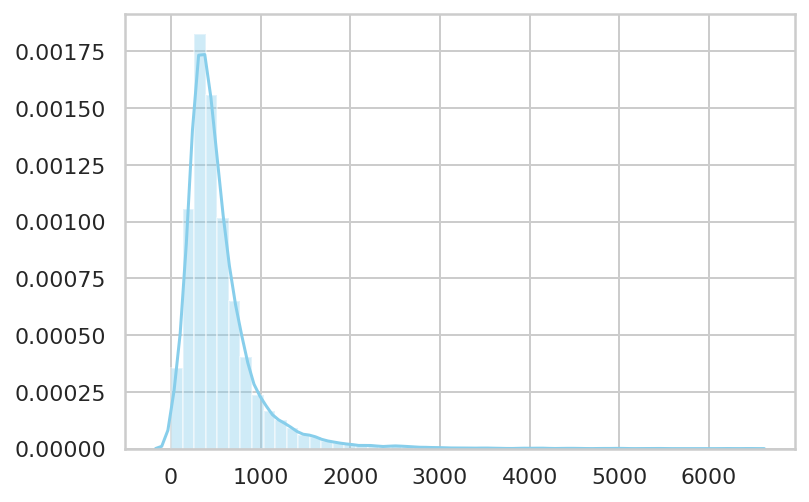

In [20]:
sns.distplot(housing_df.select('totbdrms').toPandas(), color="skyblue")

In [21]:

## Distribution of the median age of the people living in the area
# group by housingmedianage and see the distribution
result_df = housing_df.groupBy("medage").count().sort("medage", ascending=False)



result_df.show(10)



+------+-----+
|medage|count|
+------+-----+
|  52.0| 1273|
|  51.0|   48|
|  50.0|  136|
|  49.0|  134|
|  48.0|  177|
|  47.0|  198|
|  46.0|  245|
|  45.0|  294|
|  44.0|  356|
|  43.0|  353|
+------+-----+
only showing top 10 rows



<AxesSubplot:xlabel='medage'>

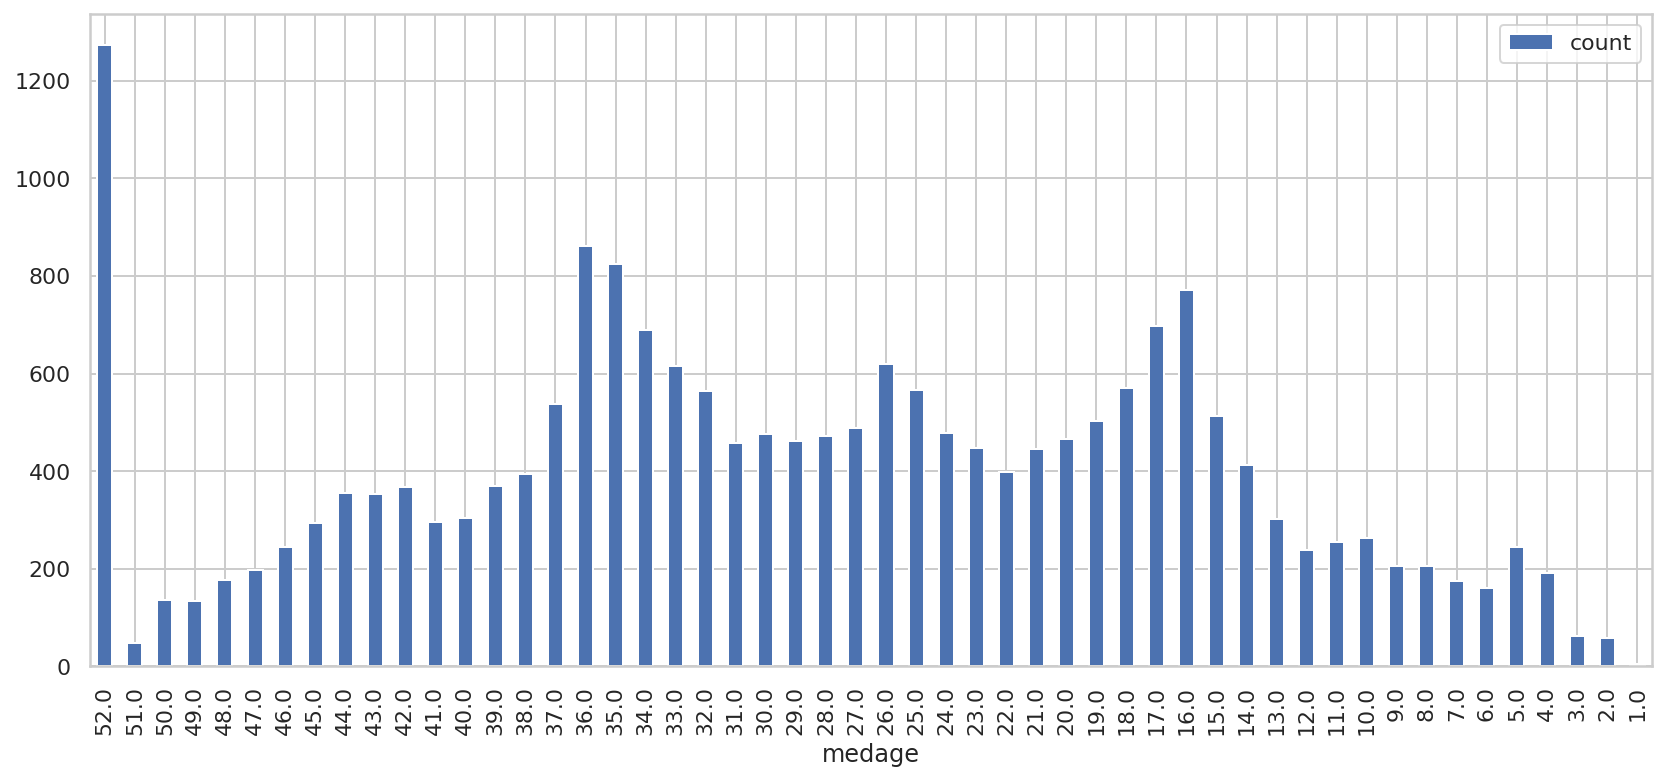

In [22]:
result_df.toPandas().plot.bar(x='medage',figsize=(14, 6))

In [23]:
(housing_df.describe().select(
                    "summary",
                    F.round("medage", 2).alias("medage"),
                    F.round("totrooms", 2).alias("totrooms"),
                    F.round("totbdrms", 2).alias("totbdrms"),
                    F.round("pop", 2).alias("pop"),
                    F.round("houshlds", 2).alias("houshlds"),
                    F.round("medinc", 2).alias("medinc"),
                    F.round("medhv", 2).alias("medhv"))
                    .show())


+-------+-------+--------+--------+-------+--------+-------+---------+
|summary| medage|totrooms|totbdrms|    pop|houshlds| medinc|    medhv|
+-------+-------+--------+--------+-------+--------+-------+---------+
|  count|20640.0| 20640.0| 20640.0|20640.0| 20640.0|20640.0|  20640.0|
|   mean|  28.64| 2635.76|   537.9|1425.48|  499.54|   3.87|206855.82|
| stddev|  12.59| 2181.62|  421.25|1132.46|  382.33|    1.9|115395.62|
|    min|    1.0|     2.0|     1.0|    3.0|     1.0|    0.5|  14999.0|
|    max|   52.0| 39320.0|  6445.0|35682.0|  6082.0|   15.0| 500001.0|
+-------+-------+--------+--------+-------+--------+-------+---------+



## Preprocessing The Target Values

First, let's start with the medianHouseValue, our dependent variable. To facilitate our working with the target values, we will express the house values in units of 100,000. That means that a target such as 452600.000000 should become 4.526:

In [24]:
housing_df = housing_df.withColumn("medhv", col("medhv")/100000)

In [25]:
housing_df.show(2)

+-------+-----+------+--------+--------+------+--------+------+-----+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|
+-------+-----+------+--------+--------+------+--------+------+-----+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|
+-------+-----+------+--------+--------+------+--------+------+-----+
only showing top 2 rows



## Feature Engineering

Now that we have adjusted the values in medianHouseValue, we will now add the following columns to the data set:

    Rooms per household which refers to the number of rooms in households per block group;
    Population per household, which basically gives us an indication of how many people live in households per block group; And
    Bedrooms per room which will give us an idea about how many rooms are bedrooms per block group;

As we're working with DataFrames, we can best use the select() method to select the columns that we're going to be working with, namely totalRooms, households, and population. Additionally, we have to indicate that we're working with columns by adding the col() function to our code. Otherwise, we won't be able to do element-wise operations like the division that we have in mind for these three variables:

In [26]:
housing_df.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

In [27]:
# Add the new columns to `df`
housing_df = (housing_df.withColumn("rmsperhh", F.round(col("totrooms")/col("houshlds"), 2))
                       .withColumn("popperhh", F.round(col("pop")/col("houshlds"), 2))
                       .withColumn("bdrmsperrm", F.round(col("totbdrms")/col("totrooms"), 2)))
housing_df.show(2)

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|    6.98|    2.56|      0.15|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|    6.24|    2.11|      0.16|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
only showing top 2 rows



In [28]:
housing_df = housing_df.select("medhv", 
                              "totbdrms", 
                              "pop", 
                              "houshlds", 
                              "medinc", 
                              "rmsperhh", 
                              "popperhh", 
                              "bdrmsperrm")

housing_df.show(2)

+-----+--------+------+--------+------+--------+--------+----------+
|medhv|totbdrms|   pop|houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|
+-----+--------+------+--------+------+--------+--------+----------+
|4.526|   129.0| 322.0|   126.0|8.3252|    6.98|    2.56|      0.15|
|3.585|  1106.0|2401.0|  1138.0|8.3014|    6.24|    2.11|      0.16|
+-----+--------+------+--------+------+--------+--------+----------+
only showing top 2 rows



##  Feature Extraction

Now that we have re-ordered the data, we're ready to normalize the data. We will choose the features to be normalized.

In [29]:
featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm"]
# put features into a feature vector column
assembler = VectorAssembler(inputCols=featureCols, outputCol="features") 
assembled_df = assembler.transform(housing_df)

['medhv',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'rmsperhh',
 'popperhh',
 'bdrmsperrm',
 'features']

/home/oscar/py3/lib/python3.6/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


<AxesSubplot:>

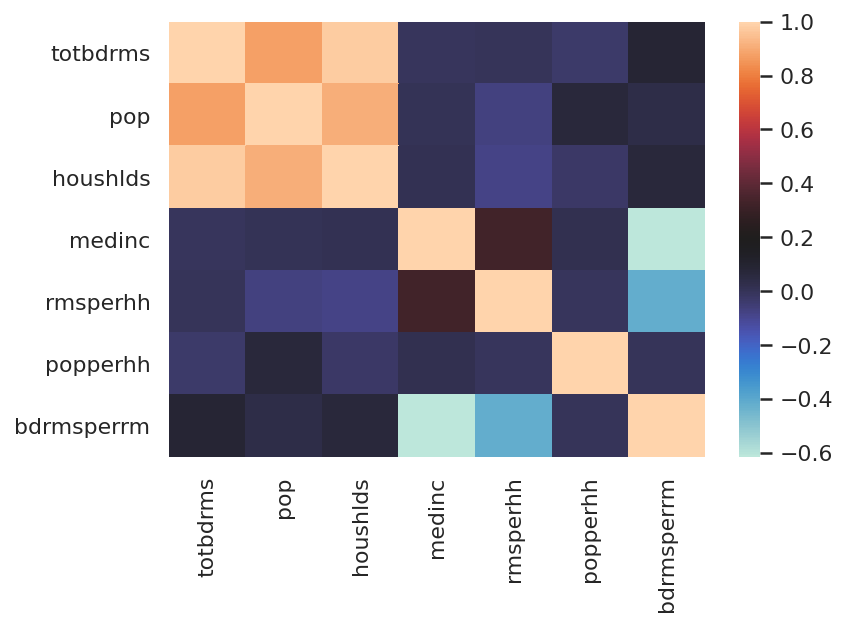

In [30]:
assembled_df.columns
matrix = Correlation.corr(assembled_df, 'features')

corrmatrix = matrix.collect()[0][0].toArray().tolist()

#Converst to pandas dataframe
df_corr = pd.DataFrame(corrmatrix, columns = featureCols , index = featureCols)

#plot correlation matrix by using seaborn
sns.heatmap(df_corr,cmap='icefire')


In [31]:


assembled_df.show(10, truncate=False)



+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|medhv|totbdrms|pop   |houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|features                                               |
+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|4.526|129.0   |322.0 |126.0   |8.3252|6.98    |2.56    |0.15      |[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |
|3.585|1106.0  |2401.0|1138.0  |8.3014|6.24    |2.11    |0.16      |[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|
|3.521|190.0   |496.0 |177.0   |7.2574|8.29    |2.8     |0.13      |[190.0,496.0,177.0,7.257400035858154,8.29,2.8,0.13]    |
|3.413|235.0   |558.0 |219.0   |5.6431|5.82    |2.55    |0.18      |[235.0,558.0,219.0,5.643099784851074,5.82,2.55,0.18]   |
|3.422|280.0   |565.0 |259.0   |3.8462|6.28    |2.18    |0.17      |[280.0,565.0,259.0,3.8461999893188477,6.28,2.18,0.17]  |


# Standard Scaler

In [32]:
# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")
# Fit the DataFrame to the scaler
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)
scaled_df.select("features", "features_scaled").show(10, truncate=False)


+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|features                                               |features_scaled                                                                                                                       |
+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |[0.30623297630686513,0.2843362208866199,0.3295584480852433,4.38209543579743,2.8211223886115664,0.24648542140099877,2.5828740130262697]|
|[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|[2.6255323394991694,2.1201592122632746,2.9764882057222772,4.36956799913841,2.522034914747303,0.20315790592035446,2.755065613894688]   |
|[190.0,496.0,177.0,7.2574000358581

In [33]:


# Split the data into train and test sets
train_data, test_data = scaled_df.randomSplit([.8,.2], seed=rnd_seed)



In [34]:
train_data.columns

['medhv',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'rmsperhh',
 'popperhh',
 'bdrmsperrm',
 'features',
 'features_scaled']

Create an ElasticNet model:

ElasticNet is a linear regression model trained with L1 and L2 prior as regularizer. This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge. We control the convex combination of L1 and L2 using the l1_ratio parameter.

Elastic-net is useful when there are multiple features which are correlated with one another. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both.

A practical advantage of trading-off between Lasso and Ridge is it allows Elastic-Net to inherit some of Ridge’s stability under rotation.

The objective function to minimize is in this case:
minw12nsamples∥Xw−y∥22+αλ∥Xw−y∥1+α(1−λ)2∥w∥22

http://scikit-learn.org/stable/modules/linear_model.html#elastic-net

In [35]:
lr = (LinearRegression(featuresCol='features_scaled', labelCol="medhv", predictionCol='predmedhv', 
                               maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False))


In [36]:


# Fit the data to the model
linearModel = lr.fit(train_data)



In [37]:
# Coefficients for the model
linearModel.coefficients

DenseVector([0.0, 0.0, 0.0, 0.5262, 0.0, 0.0, 0.0])

In [38]:
featureCols

['totbdrms', 'pop', 'houshlds', 'medinc', 'rmsperhh', 'popperhh', 'bdrmsperrm']

In [39]:
# Generate predictions
predictions = linearModel.transform(test_data)

In [40]:


# Extract the predictions and the "known" correct labels
predandlabels = predictions.select("predmedhv", "medhv")



In [41]:
predandlabels.show()

+------------------+-------+
|         predmedhv|  medhv|
+------------------+-------+
|1.1498290146733698|0.14999|
| 1.303758290180578|  0.225|
|1.7529725743151858|  0.225|
|1.6094289295308721|  0.269|
|1.5956645319495766|  0.344|
|1.2917940087238424|  0.367|
|1.8668547795751218|  0.375|
|1.3694233397856368|  0.394|
| 1.530553343912004|  0.398|
|1.5715143715849273|  0.409|
|1.3261913014043996|  0.417|
|1.2299232046905868|  0.425|
| 1.484164070093314|  0.425|
|1.3510338217435216|   0.43|
|1.2619110212709583|  0.436|
|1.3350814464678742|   0.44|
|1.4832778453641753|   0.44|
|1.4337313361080326|  0.444|
|1.3691187093204964|  0.445|
|1.4752185586821598|  0.446|
+------------------+-------+
only showing top 20 rows



In [42]:
#Using the LinearRegressionModel.summary attribute:
#Next, we can also use the summary attribute to pull up the rootMeanSquaredError and the r2.
print("RMSE: {0}".format(linearModel.summary.rootMeanSquaredError))
print("MAE: {0}".format(linearModel.summary.meanAbsoluteError))
print("R2: {0}".format(linearModel.summary.r2))

RMSE: 0.881985204526886
MAE: 0.678289531991799
R2: 0.4180854895364574


In [43]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(predandlabels)))

RMSE: 0.8677342923034236


In [44]:


evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(predandlabels)))



MAE: 0.673609774576463


In [45]:


evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(predandlabels)))



R2: 0.42517112885139363


In [46]:
metrics = RegressionMetrics(predandlabels.rdd)


In [47]:
print("RMSE: {0}".format(metrics.rootMeanSquaredError))
print("MAE: {0}".format(metrics.meanAbsoluteError))
print("R2: {0}".format(metrics.r2))

RMSE: 0.8677342923034236
MAE: 0.673609774576463
R2: 0.42517112885139363


In [48]:
spark.stop()

In [49]:
sns.scatterplot(x=y_test, y=predict data=)

SyntaxError: invalid syntax (<ipython-input-49-0c66ac6c67e7>, line 1)

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import ChiSquareTest

data = [(0.0, Vectors.dense(0.5, 10.0)),
        (0.0, Vectors.dense(1.5, 20.0)),
        (1.0, Vectors.dense(1.5, 30.0)),
        (0.0, Vectors.dense(3.5, 30.0)),
        (0.0, Vectors.dense(3.5, 40.0)),
        (1.0, Vectors.dense(3.5, 40.0))]
df = spark.createDataFrame(data, ["label", "features"])

r = ChiSquareTest.test(df, "features", "label").head()



print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))

In [ ]:
df.show()

In [ ]:
sns.scatterplot(x="medhv", y="predmedhv" , data =predandlabels.toPandas())

In [ ]:
predandlabels.toPandas()